Este trabajo es acerca del reconocimiento de signos de la Lengua de Señas Mexicana (LSM)
utilizando como base de datos un conjunto de integración propia y que consta de 21
signos estáticos. Se examina esta base de datos de forma general y se realiza la implementación de tres
redes neuronales convolucionales, así como un clasificador basado en el algorithmo "K vecinos
más cercanos".

## Configuración (para todos los modelos)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns

### Alternativas para cargar el dataset

#### Desde Google Drive

In [ ]:
# Código para leer el dataset desde google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Autenticar la cuenta
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Leyendo el dataset almacenado en google drive
downloaded = drive.CreateFile({'id':'1FyF_Ut7WUxJ56FarHsxYbpY_DtN3HNLB'}) 
downloaded.GetContentFile('LSM_reduced.csv') 
data = pd.read_csv('LSM_reduced.csv')

#### O desde el equipo en la carpeta de trabajo

In [2]:
datos=pd.read_csv('/home/estevez/Documentos/Programas Python/dataTesis/LSM_reduced.csv')

### Visualización del Dataset

In [3]:
# Generando el vector de etiquetas

target= np.full((500,1),30)
for i in np.arange(21):
    aux = np.full((500,1),i)
    target = np.vstack((target,aux))
    
target = np.delete(target,slice(0,500),0)
target=target.reshape(10500) #target contiene array del 0-20

<AxesSubplot:ylabel='count'>

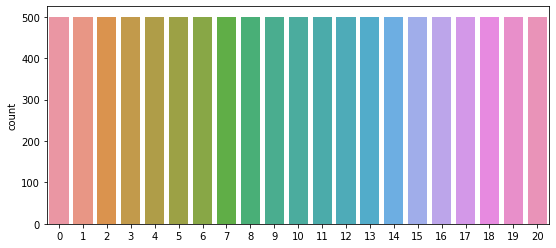

In [4]:
# Mostrando etiquetas y datos balanceados

target= np.reshape(target,10500)
plt.figure(figsize = (9,4))
sns.countplot(x =target)

In [7]:
# Dividiendo aleatoria y estratificadamente los conjuntos de entrenamiento y pruebas

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(datos, target, test_size=0.2,random_state=0,stratify=target)

X_train=np.array(X_train,dtype='int')
X_test=np.array(X_test,dtype='int')

# Normalización

X_train=X_train/255
X_test=X_test/255

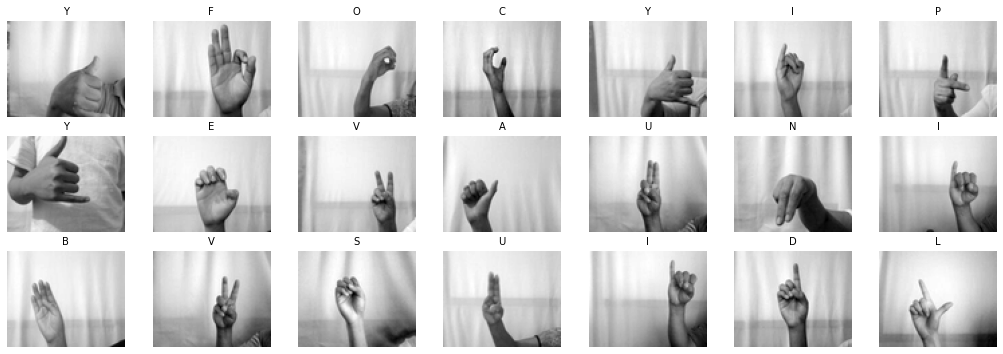

In [12]:
# Visualizando imagenes aleatorias

labels=["A","B","C","D","E","F","G","H","I","L","M","N","O","P","R","S","T","U","V","W","Y"]

ancho=7
alto=3
fig,axes=plt.subplots(alto,ancho,figsize=(18,6))
axes=axes.ravel()
for i in np.arange(0,ancho*alto):
  indx=np.random.randint(low=0,high=8000)
  axes[i].imshow(X_train[indx,:].reshape(72,88),cmap='gray')
  axes[i].set_title(labels[np.int(y_train[indx])],fontsize=10)
  axes[i].axis('off')
plt.subplots_adjust(hspace=0.2,wspace=0.1)


In [13]:
# Codificación One-Hot

def one_hot(x, n_clases=21):
  r=np.zeros((x.shape[0],n_clases))
  for i in np.arange(n_clases):
    r[:,i]=(x==i)*1
  return r

y_orig=y_test
y_test=one_hot(y_test)
y_train=one_hot(y_train)

In [14]:
# Generación del nuevo conjunto de entrenamiento y validación

from sklearn.model_selection import train_test_split
X_train, X_validate,y_train,y_validate=train_test_split(X_train,y_train,test_size=0.15,random_state=0)

In [15]:
# Se reacomodan los conjuntos para su entrada en la Red Neuronal

X_train=X_train.reshape(X_train.shape[0],*(72,88,1))
X_test=X_test.reshape(X_test.shape[0],*(72,88,1))
X_validate=X_validate.reshape(X_validate.shape[0],*(72,88,1))

In [11]:
# Bibliotecas básicas para los modelos

import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam

In [2]:
# Funciones para obtener precisión, sensibilidad (recall) y f1-score

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
# Hyperparámetros generales

classes = 21
epochs = 30
batch_size = 128

## Modelos con el conjunto de entrenamiento y validación

### AlexNet

In [9]:
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization

#np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(72,88,1), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(21))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
#AlexNet.summary()

In [ ]:
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
#Training the model
import time
start = time.time()
history_alexNet = AlexNet.fit(X_train, y_train, 
                   validation_data=(X_validate, y_validate),
                   epochs=epochs,
                   batch_size=batch_size)
training_time = time.time() - start
print("Time taken to train model: ", training_time)

Epoch 1/30
56/56 [==============================] - 4s 50ms/step - loss: 1.9941 - accuracy: 0.4495 - f1_m: 0.2294 - precision_m: 0.8028 - recall_m: 0.1472 - val_loss: 5.5835 - val_accuracy: 0.0476 - val_f1_m: 0.0477 - val_precision_m: 0.0477 - val_recall_m: 0.0477
Epoch 2/30
56/56 [==============================] - 2s 43ms/step - loss: 0.6174 - accuracy: 0.9115 - f1_m: 0.8134 - precision_m: 0.9722 - recall_m: 0.7015 - val_loss: 7.3716 - val_accuracy: 0.0476 - val_f1_m: 0.0477 - val_precision_m: 0.0477 - val_recall_m: 0.0477
Epoch 3/30
56/56 [==============================] - 2s 43ms/step - loss: 0.3746 - accuracy: 0.9687 - f1_m: 0.9212 - precision_m: 0.9884 - recall_m: 0.8630 - val_loss: 6.3042 - val_accuracy: 0.0476 - val_f1_m: 0.0477 - val_precision_m: 0.0477 - val_recall_m: 0.0477
Epoch 4/30
56/56 [==============================] - 2s 43ms/step - loss: 0.3259 - accuracy: 0.9721 - f1_m: 0.9408 - precision_m: 0.9884 - recall_m: 0.8982 - val_loss: 7.4898 - val_accuracy: 0.0476 - val_f1

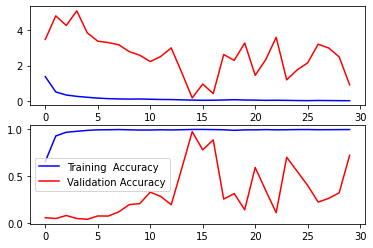

In [ ]:
#After successful training, we will visualize its performance.

import matplotlib.pyplot as plt
#Plotting the training and validation loss

f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(history_alexNet.history['loss'],color='b',label='Training Loss')
ax[0].plot(history_alexNet.history['val_loss'],color='r',label='Validation Loss')

#Plotting the training accuracy and validation accuracy
ax[1].plot(history_alexNet.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history_alexNet.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

### 1a variación AlexNet

In [5]:
model=Sequential()
model.add(Conv2D(64,kernel_size=(3,3),input_shape=(72,88,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.20))
model.add(Dense(21, activation = 'softmax'))

In [4]:
#model.summary()

In [6]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
import time
start = time.time()
history = model.fit(X_train, y_train, 
                   validation_data=(X_validate, y_validate),
                   epochs=epochs,
                   batch_size=batch_size)
training_time = time.time() - start
print("Time taken to train model: ", training_time)

Epoch 1/30
56/56 [==============================] - 3s 46ms/step - loss: 3.0462 - accuracy: 0.0505 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.0196 - val_accuracy: 0.1143 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
56/56 [==============================] - 2s 37ms/step - loss: 2.8672 - accuracy: 0.1369 - f1_m: 0.0070 - precision_m: 0.1077 - recall_m: 0.0037 - val_loss: 2.1879 - val_accuracy: 0.3738 - val_f1_m: 0.0868 - val_precision_m: 0.5907 - val_recall_m: 0.0470
Epoch 3/30
56/56 [==============================] - 2s 37ms/step - loss: 2.0226 - accuracy: 0.3796 - f1_m: 0.1905 - precision_m: 0.7016 - recall_m: 0.1130 - val_loss: 1.3321 - val_accuracy: 0.6278 - val_f1_m: 0.4977 - val_precision_m: 0.8559 - val_recall_m: 0.3515
Epoch 4/30
56/56 [==============================] - 2s 37ms/step - loss: 1.2892 - accuracy: 0.6019 - f1_m: 0.5202 - precision_m: 0.8260 - recall_m: 0.3832 - val_loss: 0.8245 - val_a

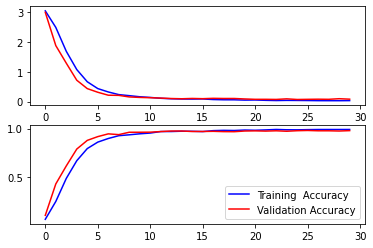

In [ ]:
f,ax=plt.subplots(2,1) 

ax[0].plot(history.history['loss'],color='b',label='Training Loss')
ax[0].plot(history.history['val_loss'],color='r',label='Validation Loss')

ax[1].plot(history.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

### 2a Variación AlexNet

In [ ]:
model1 = Sequential()

model1.add(Conv2D(32, kernel_size=4, activation='relu', input_shape=(72, 88, 1), padding='same'))
model1.add(Dropout(0.25))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, kernel_size=4, activation='relu', strides=3))
model1.add(Dropout(0.25))

model1.add(Conv2D(128, kernel_size=4, activation='relu', strides=3))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(classes, activation='softmax'))

model1.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy',f1_m,precision_m, recall_m])

In [7]:
#model1.summary()

In [ ]:
import time
start = time.time()
history1 = model1.fit(X_train, y_train, 
                   validation_data=(X_validate, y_validate),
                   epochs=epochs,
                   batch_size=batch_size)
training_time = time.time() - start
print("Time taken to train model: ", training_time)

Epoch 1/30
56/56 [==============================] - 3s 33ms/step - loss: 3.0485 - accuracy: 0.0445 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 3.0428 - val_accuracy: 0.0452 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/30
56/56 [==============================] - 1s 24ms/step - loss: 2.9960 - accuracy: 0.0770 - f1_m: 0.0014 - precision_m: 0.0302 - recall_m: 7.2705e-04 - val_loss: 2.6707 - val_accuracy: 0.2048 - val_f1_m: 0.0465 - val_precision_m: 0.4165 - val_recall_m: 0.0247
Epoch 3/30
56/56 [==============================] - 1s 24ms/step - loss: 2.4683 - accuracy: 0.2469 - f1_m: 0.0640 - precision_m: 0.5852 - recall_m: 0.0346 - val_loss: 1.9179 - val_accuracy: 0.4540 - val_f1_m: 0.1592 - val_precision_m: 0.7072 - val_recall_m: 0.0903
Epoch 4/30
56/56 [==============================] - 1s 25ms/step - loss: 1.8352 - accuracy: 0.4230 - f1_m: 0.2647 - precision_m: 0.7101 - recall_m: 0.1650 - val_loss: 1.3879 - v

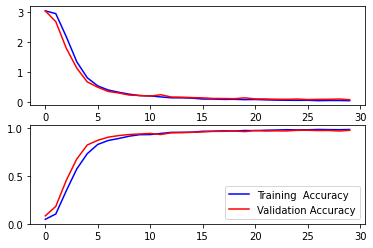

In [ ]:
f,ax=plt.subplots(2,1) 

ax[0].plot(history1.history['loss'],color='b',label='Training Loss')
ax[0].plot(history1.history['val_loss'],color='r',label='Validation Loss')

ax[1].plot(history1.history['accuracy'],color='b',label='Training  Accuracy')
ax[1].plot(history1.history['val_accuracy'],color='r',label='Validation Accuracy')

plt.legend()

### Comparativa del rendimiento de los tres modelos propuestos

Comportamiento de la exactitud ante el conjunto de validación

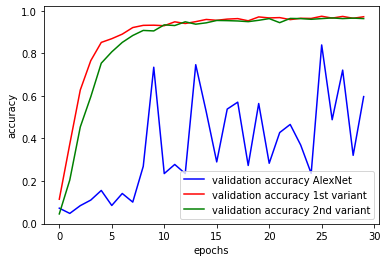

In [ ]:
plt.plot(history_alexNet.history['val_accuracy'],color='b',label='validation accuracy AlexNet')
plt.plot(history.history['val_accuracy'],color='r',label='validation accuracy 1st variant')
plt.plot(history1.history['val_accuracy'],color='g',label='validation accuracy 2nd variant')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Comportamiento de la exactitud ante el conjunto de entrenamiento

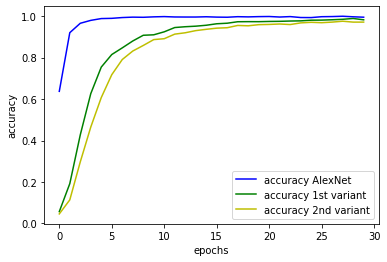

In [ ]:
plt.plot(history_alexNet.history['accuracy'],color='b',label='accuracy AlexNet')
plt.plot(history.history['accuracy'],color='g',label='accuracy 1st variant')
plt.plot(history1.history['accuracy'],color='y',label='accuracy 2nd variant')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Comportamiento de la función de pérdida ante el conjunto de validación

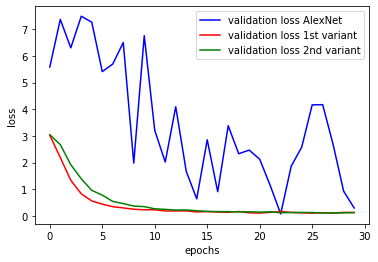

In [ ]:
plt.plot(history_alexNet.history['val_loss'],color='b',label='validation loss AlexNet')
plt.plot(history.history['val_loss'],color='r',label='validation loss 1st variant')
plt.plot(history1.history['val_loss'],color='g',label='validation loss 2nd variant')
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.legend(['accuracy','loss'])
plt.legend()
plt.show()

Comportamiento de la función de pérdida ante el conjunto de entrenamiento

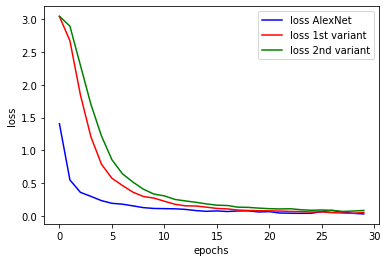

In [ ]:
plt.plot(history_alexNet.history['loss'],color='b',label='loss AlexNet')
plt.plot(history.history['loss'],color='r',label='loss 1st variant')
plt.plot(history1.history['loss'],color='g',label='loss 2nd variant')
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.legend(['accuracy','loss'])
plt.legend()
plt.show()

## Entrenamiento de los modelos sin el conjunto de validación

En esta sección se evalúa el comportamiento de los modelos con todo el dataset, 80% para entrenamiento y 20% para pruebas. 

### AlexNet

In [10]:
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(72,88,1), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(21))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))


In [ ]:
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
import time
start = time.time()
history_alexNet = AlexNet.fit(X_train, y_train,
                   epochs=epochs,
                   batch_size=batch_size)
training_time = time.time() - start
print("Time taken to train model: ", training_time)

Epoch 1/30
56/56 [==============================] - 4s 42ms/step - loss: 1.9491 - accuracy: 0.4731 - f1_m: 0.2318 - precision_m: 0.7953 - recall_m: 0.1507
Epoch 2/30
56/56 [==============================] - 2s 40ms/step - loss: 0.5653 - accuracy: 0.9225 - f1_m: 0.8431 - precision_m: 0.9805 - recall_m: 0.7407
Epoch 3/30
56/56 [==============================] - 2s 40ms/step - loss: 0.3700 - accuracy: 0.9699 - f1_m: 0.9259 - precision_m: 0.9888 - recall_m: 0.8710
Epoch 4/30
56/56 [==============================] - 2s 40ms/step - loss: 0.2806 - accuracy: 0.9819 - f1_m: 0.9584 - precision_m: 0.9934 - recall_m: 0.9261
Epoch 5/30
56/56 [==============================] - 2s 40ms/step - loss: 0.2349 - accuracy: 0.9863 - f1_m: 0.9734 - precision_m: 0.9943 - recall_m: 0.9535
Epoch 6/30
56/56 [==============================] - 2s 40ms/step - loss: 0.2002 - accuracy: 0.9907 - f1_m: 0.9798 - precision_m: 0.9955 - recall_m: 0.9648
Epoch 7/30
56/56 [==============================] - 2s 40ms/step - los

In [ ]:
plt.plot(history_alexNet.history['accuracy'],color='b',label='accuracy AlexNet')
plt.xlabel('epochs')
plt.ylabel('accuracy')
#plt.legend(['accuracy','loss'])
plt.legend()
plt.show()

NameError: ignored

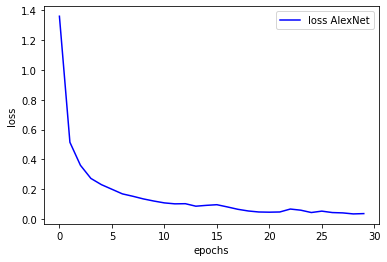

In [ ]:
plt.plot(history_alexNet.history['loss'],color='b',label='loss AlexNet')
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.legend(['accuracy','loss'])
plt.legend()
plt.show()

In [ ]:
prediction_AlexNet = AlexNet.predict(X_test)
from sklearn.metrics import accuracy_score
print("Test Accuracy: " + str(accuracy_score(y_test, prediction_AlexNet.round())))
labels=["A","B","C","D","E","F","G","H","I","L","M","N","O","P","R","S","T","U","V","W","Y"]

Test Accuracy: 0.2319047619047619


### Primera variación AlexNet

In [ ]:
model=Sequential()
model.add(Conv2D(64,kernel_size=(3,3),input_shape=(72,88,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.20))
model.add(Dense(21, activation = 'softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
import time
start = time.time()
history = model.fit(X_train, y_train,
                   epochs=epochs,
                   batch_size=batch_size)
training_time = time.time() - start
print("Time taken to train model: ", training_time)

Epoch 1/30
56/56 [==============================] - 2s 34ms/step - loss: 3.0461 - accuracy: 0.0533 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2/30
56/56 [==============================] - 2s 34ms/step - loss: 2.8044 - accuracy: 0.1468 - f1_m: 0.0195 - precision_m: 0.2692 - recall_m: 0.0104
Epoch 3/30
56/56 [==============================] - 2s 34ms/step - loss: 1.8203 - accuracy: 0.4510 - f1_m: 0.3005 - precision_m: 0.7300 - recall_m: 0.1928
Epoch 4/30
56/56 [==============================] - 2s 34ms/step - loss: 1.2703 - accuracy: 0.5973 - f1_m: 0.5427 - precision_m: 0.8024 - recall_m: 0.4118
Epoch 5/30
56/56 [==============================] - 2s 34ms/step - loss: 0.8988 - accuracy: 0.7122 - f1_m: 0.6909 - precision_m: 0.8418 - recall_m: 0.5869
Epoch 6/30
56/56 [==============================] - 2s 34ms/step - loss: 0.7201 - accuracy: 0.7694 - f1_m: 0.7554 - precision_m: 0.8622 - recall_m: 0.6728
Epoch 7/30
56/56 [==============================] - 2s 34m

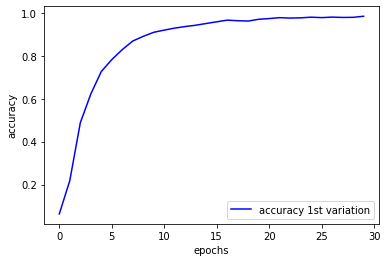

In [ ]:
plt.plot(history.history['accuracy'],color='b',label='accuracy 1st variation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
#plt.legend(['accuracy','loss'])
plt.legend()
plt.show()

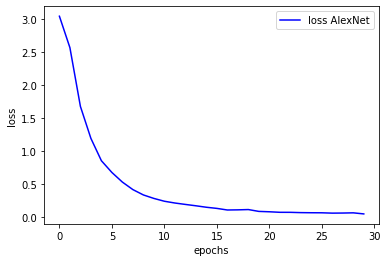

In [ ]:
plt.plot(history.history['loss'],color='b',label='loss AlexNet')
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.legend(['accuracy','loss'])
plt.legend()
plt.show()

In [ ]:
prediction_model = model.predict(X_test)
from sklearn.metrics import accuracy_score
print("Test Accuracy: " + str(accuracy_score(y_test, prediction_model.round())))
labels=["A","B","C","D","E","F","G","H","I","L","M","N","O","P","R","S","T","U","V","W","Y"]

Test Accuracy: 0.9680952380952381


### 2a variación AlexNet

In [ ]:
model1 = Sequential()

model1.add(Conv2D(32, kernel_size=4, activation='relu', input_shape=(72, 88, 1), padding='same'))
model1.add(Dropout(0.25))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, kernel_size=4, activation='relu', strides=3))
model1.add(Dropout(0.25))

model1.add(Conv2D(128, kernel_size=4, activation='relu', strides=3))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(classes, activation='softmax'))

model1.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
import time
start = time.time()
history1 = model1.fit(X_train, y_train,
                   epochs=epochs,
                   batch_size=batch_size)
training_time = time.time() - start
print("Time taken to train model: ", training_time)

Epoch 1/30
56/56 [==============================] - 2s 23ms/step - loss: 3.0475 - accuracy: 0.0526 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00
Epoch 2/30
56/56 [==============================] - 1s 22ms/step - loss: 2.9443 - accuracy: 0.0958 - f1_m: 0.0034 - precision_m: 0.0629 - recall_m: 0.0018
Epoch 3/30
56/56 [==============================] - 1s 22ms/step - loss: 2.3538 - accuracy: 0.2757 - f1_m: 0.0902 - precision_m: 0.6368 - recall_m: 0.0499
Epoch 4/30
56/56 [==============================] - 1s 22ms/step - loss: 1.6034 - accuracy: 0.4985 - f1_m: 0.3704 - precision_m: 0.7897 - recall_m: 0.2464
Epoch 5/30
56/56 [==============================] - 1s 22ms/step - loss: 0.9877 - accuracy: 0.6856 - f1_m: 0.6516 - precision_m: 0.8416 - recall_m: 0.5341
Epoch 6/30
56/56 [==============================] - 1s 23ms/step - loss: 0.6108 - accuracy: 0.7971 - f1_m: 0.7894 - precision_m: 0.8718 - recall_m: 0.7217
Epoch 7/30
56/56 [==============================] - 1s 23m

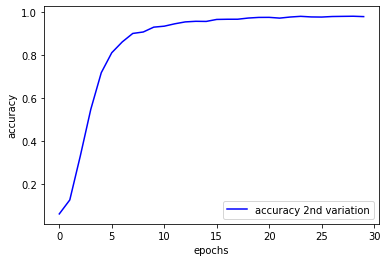

In [ ]:
plt.plot(history1.history['accuracy'],color='b',label='accuracy 2nd variation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
#plt.legend(['accuracy','loss'])
plt.legend()
plt.show()

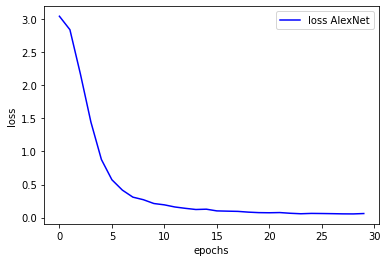

In [ ]:
plt.plot(history1.history['loss'],color='b',label='loss AlexNet')
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.legend(['accuracy','loss'])
plt.legend()
plt.show()

In [ ]:
prediction_model1 = model1.predict(X_test)
from sklearn.metrics import accuracy_score
print("Test Accuracy: " + str(accuracy_score(y_test, prediction_model1.round())))
labels=["A","B","C","D","E","F","G","H","I","L","M","N","O","P","R","S","T","U","V","W","Y"]

Test Accuracy: 0.9709523809523809


### Comparativas

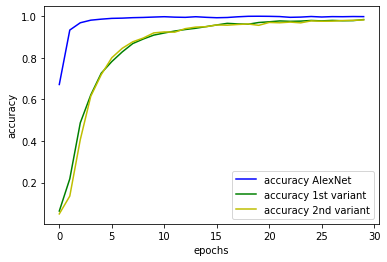

In [ ]:
plt.plot(history_alexNet.history['accuracy'],color='b',label='accuracy AlexNet')
plt.plot(history.history['accuracy'],color='g',label='accuracy 1st variant')
plt.plot(history1.history['accuracy'],color='y',label='accuracy 2nd variant')
plt.xlabel('epochs')
plt.ylabel('accuracy')
#plt.legend(['accuracy','loss'])
plt.legend()
plt.show()

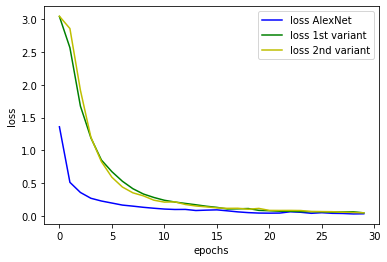

In [ ]:
plt.plot(history_alexNet.history['loss'],color='b',label='loss AlexNet')
plt.plot(history.history['loss'],color='g',label='loss 1st variant')
plt.plot(history1.history['loss'],color='y',label='loss 2nd variant')
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.legend(['accuracy','loss'])
plt.legend()
plt.show()